In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import scipy.stats
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs, plot_T_x
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj, plot_contrast_response, \
                     get_Fano, load_SSSN_variable, get_stddev_sigma
from scipy.io import loadmat
import os

In [2]:
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "/Users/sbittner/Documents/git_repos/dsn_talk/epi_figs/SSSN/"

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

data = loadmat(os.path.join("data", "AgosBiorxiv2.mat"))['data']

ind = 62
dt = 0.0005
T = 200

W_mat = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)
h = (hb+0.5*hc)[None,:]

### 3.1 Load epi distribution.

In [3]:
f_mean = 10.
f_std = 1.
alpha = 'E'

D = 4
lb = np.zeros((D,))
ub = 0.005*np.ones((D,))
sigma_eps = Parameter("sigma_eps", D, lb=lb, ub=ub)

name = "SSSN_stddev_sigma_%s_%.2E_%.2E_ind=%d" % (alpha, f_mean, f_std, ind)
parameters = [sigma_eps]
model = Model(name, parameters)

dt = 0.0005
T = 200
N = 50

stddev = get_stddev_sigma('E', W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=f_mean)
model.set_eps(stddev)

epi_df = model.get_epi_df()

epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['elemwise_fn'] = ['affine' if 'affine' in path else 'spline' for path in epi_df['path']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
epi_df['f_mean'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['f_std'] = [np.sqrt(ep['mu'][1]) for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

epi_df = epi_df[(epi_df['f_std']==f_std) & 
                (epi_df['c0']==1e-1) & 
                (epi_df['random_seed'] == 1)]

best_k = epi_df['k'].max()
df_row = epi_df.iloc[0]
dist = model.get_epi_dist(df_row, k=int(best_k))


### 3.2 Plot epi distribution.

In [4]:
M = 2000
num_plot = 300
zs = []
log_q_zs = []
T_xs = []
alphas = ['E', 'P', 'S', 'V']
z_labels = [r'$\sigma_%s$' % alpha for alpha in alphas]
np.random.seed(1)
tf.random.set_seed(1)
z, log_q_z = dist.nf(M)
z, log_q_z = z.numpy(), log_q_z.numpy()
T_x = model.eps(z).numpy()

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [20]:
def get_conditional_mode(dist, alpha, val, step=1e-6, num_steps=100):
    ind = neuron_inds[alpha]
    z0_np = ((dist.nf.lb + dist.nf.ub) / 2.)
    z0_np[ind] = val
    z = tf.Variable(initial_value=z0_np[None,:], dtype=tf.float32, trainable=True)
    
    log_q_z = dist.log_prob(z.numpy())
    
    zs = [z]
    log_q_zs = [log_q_z]
    
    for k in range(num_steps):
        grad_z = dist._gradient(z).numpy()
        z_np = z.numpy()
        z_next = z_np + step * grad_z
        z_next[0,ind] = val
        for j in range(4):
            if z_next[0,j] < lb[j]:
                z_next[0,j] = lb[j]
            if z_next[0,j] > ub[j]:
                z_next[0,j] = ub[j]
        z = tf.Variable(initial_value=z_next, 
                        dtype=tf.float32, trainable=True)
        
        log_q_z = dist.log_prob(z_next)
        zs.append(z_next[0])
        log_q_zs.append(log_q_z)
        
    return zs, log_q_zs

sigma_P_vals = np.arange(0.0005, 0.00351, 0.00025)
ridge_zs = []
ridge_log_q_zs = []
import time
for sigma_P_val in sigma_P_vals:
    time1 = time.time()
    zs, log_q_zs = get_conditional_mode(dist, 'P', sigma_P_val, step=5.0e-9, num_steps=50)
    time2 = time.time()
    ridge_zs.append(zs[-1])
    ridge_log_q_zs.append(log_q_zs[-1])
    
ridge_zs = np.array(ridge_zs)
ridge_log_q_zs = np.array(ridge_log_q_zs)

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [21]:
print(ridge_zs)

[[0.00305568 0.0005     0.00248407 0.00250349]
 [0.00303984 0.00075    0.00250359 0.00250634]
 [0.00298765 0.001      0.00249977 0.00251029]
 [0.00289767 0.00125    0.00250165 0.00249027]
 [0.00282126 0.0015     0.00249423 0.00248966]
 [0.00269427 0.00175    0.00250005 0.00247232]
 [0.00257637 0.002      0.00249824 0.00247725]
 [0.00240239 0.00225    0.00249551 0.0024901 ]
 [0.00220513 0.0025     0.00249456 0.0025023 ]
 [0.00194541 0.00275    0.00249193 0.00250578]
 [0.00164086 0.003      0.00249644 0.0025105 ]
 [0.0013198  0.00325    0.00250594 0.00249994]
 [0.00100871 0.0035     0.00251159 0.00244022]]


In [22]:
hess_z = dist.hessian(ridge_zs)
vs = []
for i, sigma_P_val in enumerate(sigma_P_vals):
    hess_z_i = hess_z[i]
    d, v = np.linalg.eig(hess_z_i)
    min_ind = np.argmin(d)
    _v = v[:,min_ind]
    if (_v[0] < 0.):
        _v = -_v
    vs.append(_v)
    
vs = np.array(vs)
print(vs)

[[ 0.99157804  0.12929305  0.00546296  0.00514665]
 [ 0.99499685  0.09930331 -0.01025213  0.00387058]
 [ 0.9592916   0.2820397   0.00392616  0.01406426]
 [ 0.93580246  0.35038143  0.0044322   0.03856101]
 [ 0.9204165   0.39074236  0.00842132  0.0091113 ]
 [ 0.8901089   0.45459577  0.01921101  0.02607206]
 [ 0.8186367   0.5741356   0.01392262 -0.00289893]
 [ 0.7992467   0.600984   -0.00237598  0.00415646]
 [ 0.7364439   0.67593205  0.01588424 -0.02267231]
 [ 0.6612895   0.74925447  0.0143876  -0.03327015]
 [ 0.5433011   0.8385524   0.03017289 -0.02726481]
 [ 0.39121574  0.9197633   0.0310041   0.0049384 ]
 [ 0.31523898  0.9488066   0.00760161  0.01823874]]


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


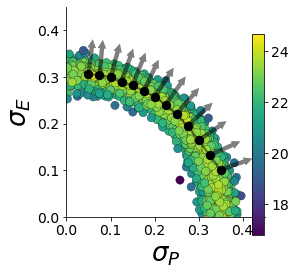

In [63]:
np.random.seed(0)
tf.random.set_seed(0)
fig, ax = pairplot(1e2*z, np.arange(2), z_labels, 
               fontsize=26, figsize=(4,4), ticksize=14, s=70,
               lb=lb, ub=0.45*np.ones((4,)), c=log_q_z, c_label='')
ridge_color = np.array([0.,0.,0.,.5])
ax.scatter(1e2*ridge_zs[:,1], 1e2*ridge_zs[:,0], c='k', s=70)
ax.plot(1e2*ridge_zs[:,1], 1e2*ridge_zs[:,0], '-', c=ridge_color)
fac = 0.00075
for i, sigma_P_val in enumerate(sigma_P_vals):
    vx = 1e2*np.array([ridge_zs[i,1], ridge_zs[i,1]+fac*vs[i,1]])
    vy = 1e2*np.array([ridge_zs[i,0], ridge_zs[i,0]+fac*vs[i,0]])
    ax.annotate("", xy=[vx[1], vy[1]], xytext=[vx[0], vy[0]], 
                 arrowprops=dict(headwidth=8, headlength=8, lw=.25, color=ridge_color))
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelE_zoom.png"))

0 0 E


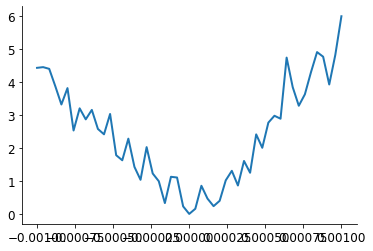

1 0 E


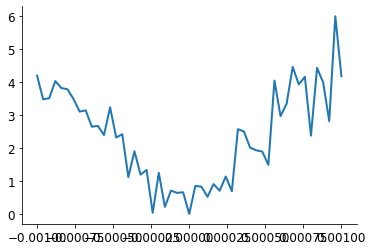

2 0 E


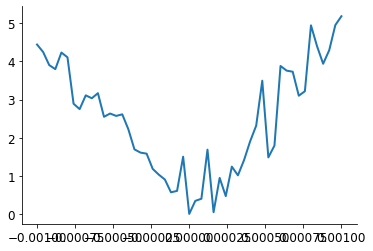

3 0 E


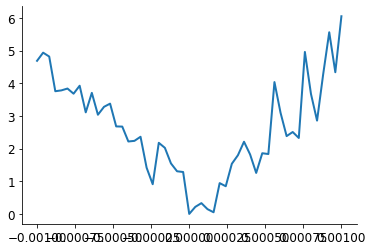

4 0 E


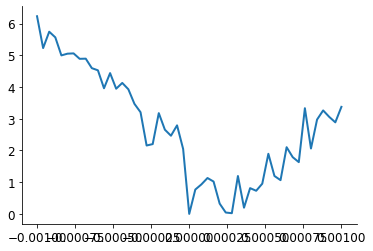

5 0 E


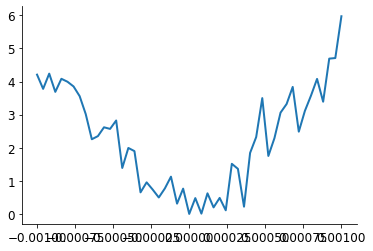

6 0 E


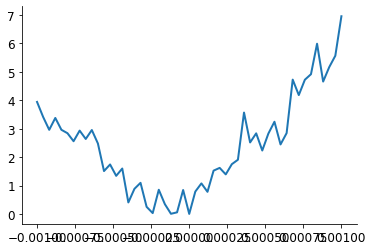

7 0 E


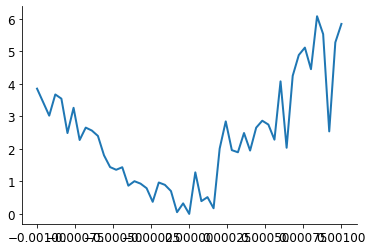

8 0 E


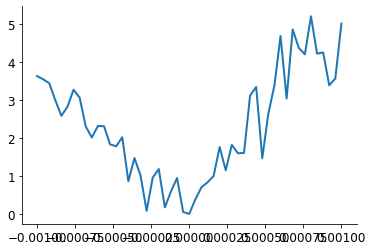

9 0 E


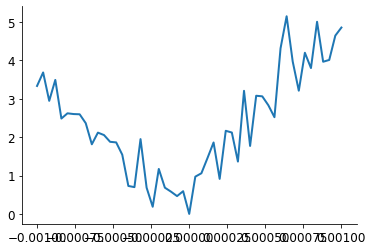

10 0 E


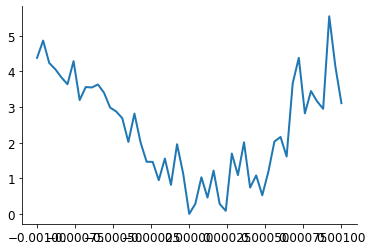

11 0 E


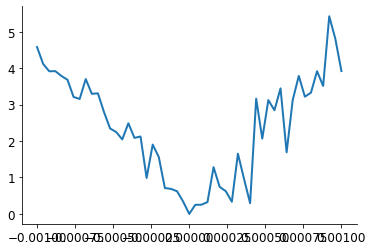

12 0 E


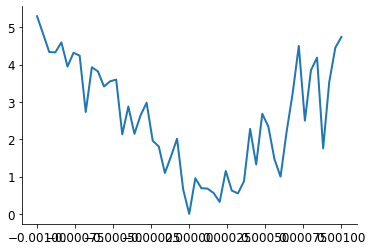

In [27]:
def sensitivity(facs, d):
    m, b, r, p, _ = scipy.stats.linregress(facs, d)
    return m, r

def rvs(D, N):
    v = np.random.normal(0., 1., (N,D))
    v = v / np.linalg.norm(v, axis=1)[:,None]
    return v

fac_lim = 0.001
n_rand = 200
v_rands = rvs(4, n_rand)
ms = []
rs = []
sens_samps = 51
facs = np.linspace(-fac_lim, fac_lim, sens_samps)
stddev_f = get_stddev_sigma('all', W_mat, h, N=2*N, dt=dt, T=300, T_ss=200, mu=f_mean)

alphas = ['E']
m_rands = []
r_rands = []
for i, sigma_P_val in enumerate(sigma_P_vals):
    z_i = ridge_zs[i][None]
    v_i = vs[i][None]
    z_perturb = z_i + facs[:,None]*v_i
    T_x_perturb = stddev_f(z_perturb)
    _m_rands = []
    _r_rands = []
    for j, alpha in enumerate(alphas):
        print(i,j,alpha)
        alpha_ind = neuron_inds[alpha]
        d = np.abs(T_x_perturb[:,alpha_ind]-T_x_perturb[(sens_samps//2),alpha_ind])
        plt.figure()
        plt.plot(facs, d)
        plt.show()
        _m, _r = sensitivity(np.abs(facs), d)
        ms.append(_m)
        rs.append(_r)
        _sens_rand = []
        for k in range(n_rand):
            z_perturb = z_i + facs[:,None]*v_rands[k,:][None,:]
            T_x_perturb = stddev_f(z_perturb)
            d = np.abs(T_x_perturb[:,alpha_ind]-T_x_perturb[(sens_samps//2),alpha_ind])
            _sens_rand.append(sensitivity(np.abs(facs), d))
        _m_rands.append(np.array([_sens_rand[j][0] for j in range(n_rand)]))
        _r_rands.append(np.array([_sens_rand[j][1] for j in range(n_rand)]))
    m_rands.append(_m_rands)
    r_rands.append(_r_rands)
m_rands = np.array(m_rands)
r_rands = np.array(r_rands)

In [40]:
dfs = []
for i, sigma_P_val in enumerate(sigma_P_vals):
    print(alphas)
    #dfs.append(pd.DataFrame({'alpha':alphas, 'sigma_P_val':sigma_P_val, 'type':'hess', 'm':ms[(1*i):(1*(i+1))]}))
    for j, alpha in enumerate(alphas):
        dfs.append(pd.DataFrame({'alpha':alpha, 'sigma_P_val':100.*sigma_P_val, 'type':'rand', 'm':m_rands[i][j]/100.}))
df = pd.concat(dfs)
print(df)

['E']
['E']
['E']
['E']
['E']
['E']
['E']
['E']
['E']
['E']
['E']
['E']
['E']
    alpha  sigma_P_val  type          m
0       E         0.05  rand   7.002126
1       E         0.05  rand   1.468062
2       E         0.05  rand  -3.036311
3       E         0.05  rand  21.854588
4       E         0.05  rand  20.821730
..    ...          ...   ...        ...
195     E         0.35  rand  12.174648
196     E         0.35  rand  23.949996
197     E         0.35  rand  30.805124
198     E         0.35  rand  32.652222
199     E         0.35  rand  -0.575095

[2600 rows x 4 columns]


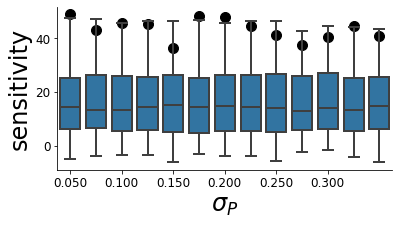

In [64]:
import seaborn as sns
"""for alpha in alphas:
    _df = df[df['alpha']==alpha]
    plt.figure(figsize=(8,4))
    ax = sns.boxplot(data=_df, x='sigma_P_val', y='m', hue='type', palette=colors)
    ax.set_ylabel('sensitivity', fontsize=18)
    plt.show()"""

plt.figure(figsize=(6,3))
ax = sns.boxplot(data=df, x='sigma_P_val', y='m', hue='alpha')
ax.set_xlabel(r'$\sigma_P$', fontsize=24)
ax.set_ylabel('sensitivity', fontsize=24)
ax.scatter(range(len(sigma_P_vals)), np.array(ms)/100., c='k')
ax.get_legend().remove()
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
xticklabels = ["%.3f" % (100*sigma_P_vals[tick]) for tick in xticks]
ax.set_xticklabels(xticklabels)
plt.show()

#ax = sns.boxplot(x=np.round(1e3*sigma_P_vals, 2), y=b_rands, color=.3*np.ones(3))
#ax.set_xlabel(r'$\sigma_P$', fontsize=fontsize)
#plt.setp(ax.get_xticklabels(), fontsize=ticksize)
#plt.setp(ax.get_yticklabels(), fontsize=ticksize)
#ax.set_ylim([-.1, .9])
#plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelE_sens.png"), transparent=True)

In [65]:
"""Fano_extra = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=300, T_ss=150, mu=ff_mean)
model.set_eps(Fano_extra)

T_x = model.eps(z).numpy()
plot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,
             x_mean=ff_mean, x_std=ff_std, figsize=None,
             xlabel=r'$F(x; z)$', ylim=None, fontsize=28)"""

"Fano_extra = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=300, T_ss=150, mu=ff_mean)\nmodel.set_eps(Fano_extra)\n\nT_x = model.eps(z).numpy()\nplot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,\n             x_mean=ff_mean, x_std=ff_std, figsize=None,\n             xlabel=r'$F(x; z)$', ylim=None, fontsize=28)"

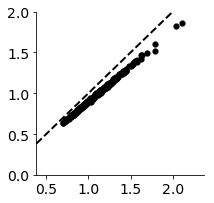

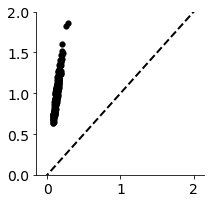

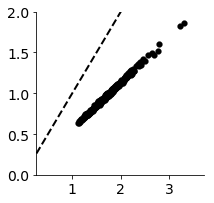

In [74]:
Fano_all = get_Fano_sigma('all', W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=ff_mean)
fano_all = Fano_all(z).numpy()

fano_labels = [r'$F_%s$' % alpha for alpha in alphas]
inhib_types = ['P', 'S', 'V']
for alpha in inhib_types:
    alpha_ind = neuron_inds[alpha]
    fano_E_alpha = np.stack((fano_all[:,0], fano_all[:,alpha_ind]), axis=1)
    fig, ax = pairplot(fano_E_alpha, np.arange(2), ['', ''],
                   fontsize=24, figsize=(3,3), ticksize=14, s=35,
                   lb=np.zeros(2,), ub=3.*np.ones((2,)), unity_line=True)
    ax.set_ylim([0., 2.])
    #plt.savefig(os.path.join(figdir, "Fig3", "PanelF_E%s.png" % alpha))
    plt.show()

In [90]:
#sigma_eps = np.array([[2.7747380e-02, 2.9908607e-02,  1.0897118e-03, 1.3312697e-05]])
sigma_eps = np.array([[0.00175, 0.00175, 0.002, 0.002]])

_c = np.linspace(0, 1, 25)

_N = 5
hs = hb[None,:] + _c[:,None]*hc[None,:]
F_means = []
F_stds = []
for m in range(200):
    sigma_eps = z[m,:][None,:]
    Fano = get_Fano('all', sigma_eps, W_mat, dt=dt, N=N, T=T)
    Fs = []
    for k in range(_N):
        print('m=%d: %2d/%2d \r' % (m+1, k+1, _N), end="")
        Fs.append(Fano(hs).numpy())
    Fs = np.array(Fs)
    F_means.append(np.mean(Fs, axis=0))
    F_stds.append(np.std(Fs, axis=0))

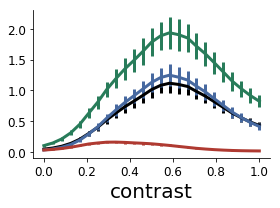

In [91]:
F_means = np.array(F_means)
F_stds = np.array(F_stds)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
fontsize= 20
for ii in range(4):
    ax.errorbar(_c, np.mean(F_means[:,:,ii], axis=0), 
                np.std(F_means[:,:,ii], axis=0), c=colors[ii], lw=3)
ax.set_xlabel('contrast', fontsize=fontsize)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelG.png"))
plt.show()

F_mean (10, 8)
F_std (10, 8)


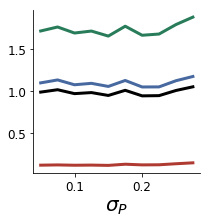

In [14]:
Ns = [50]
Ts = [150]
F_means = {}
F_stds = {}
_N = 50
for N in Ns:
    for T in Ts:
        Fano = get_Fano_sigma('all', W_mat, h, dt=dt, N=N, T=T)
        sigma_eps = ridge_zs
        Fs = []
        for k in range(_N):
            print('%2d/%2d \r' % (k+1, _N), end="")
            Fs.append(Fano(sigma_eps).numpy())
        Fs = np.array(Fs)
        F_means.update({(N,T): np.mean(Fs, axis=0)})
        F_stds.update({(N,T): np.std(Fs, axis=0)})

fig, axs = plt.subplots(len(Ns), len(Ts), figsize=(3,3))
fontsize= 20
for i, N in enumerate(Ns):
    for j, T in enumerate(Ts):
        if len(Ns) == 1:
            if len(Ts) == 1:
                ax = axs
            else:
                ax = axs[j]
        elif len(Ts) == 1:
            ax = axs[i]
        else:
            ax = axs[i,j]
        F_mean = F_means[(N,T)]
        F_std = F_stds[(N,T)]
        print('F_mean', F_mean.shape)
        print('F_std', F_std.shape)
        for ii in range(4):
            #plt.errorbar(_c, h_var[:,i], h_var[:,i+4], c=colors[i])
            #ax.errorbar(np.arange(5), F_mean[:,ii], F_std[:,ii], c=colors[ii])
            ax.plot(1e2*sigma_P_vals, F_mean[:,ii], c=colors[ii], lw=3)
            #plt.plot(_c, h_var[:,i], c=colors[i])
        if (i==(len(Ns)-1)):
            ax.set_xlabel(r'$\sigma_P$', fontsize=fontsize)
        #if (j==0):
            #ax.set_ylabel(r'$F(x; z)$', fontsize=fontsize)
        #ax.set_ylim([0, 0.05])
plt.show()


0.05345521893470395
198.12273 202.37111 0.33196604


(0, 0.003)

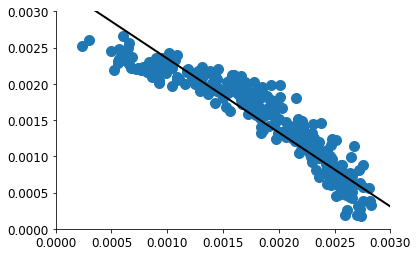

In [110]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(z[:,:2], T_x[:,0])
print(linreg.score(z[:,:2], T_x[:,0]))
a, b = linreg.coef_
c = linreg.intercept_
print(a,b,c)
x2 = np.linspace(0., 0.003, 7)
x1 = (1./a)*(-b*x2 - c + 1)
plt.figure()
plt.scatter(z[:,1], z[:,0])
plt.plot(x2, x1, 'k')
plt.xlim([0,.003])
plt.ylim([0,.003])

In [125]:
fano = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=1000, T_ss=500, mu=ff_mean)
model.set_eps(fano)
T_x2 = model.eps(z)

0.2013501684955349
183393.33 152147.11 -0.06324375


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


(0, 0.003)

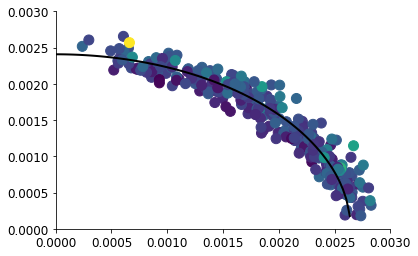

In [129]:
linreg = LinearRegression().fit(z[:,:2]**2, T_x[:,0])

print(linreg.score(z[:,:2]**2, T_x[:,0]))
a, b = linreg.coef_
c = linreg.intercept_
print(a,b,c)
x2 = np.linspace(0., 0.003, 100)
x1 = np.sqrt((1./a)*(-b*(x2**2) - c + 1.))
plt.figure()
plt.scatter(z[:,1], z[:,0], c=T_x[:,0])
plt.plot(x2, x1, 'k')
plt.xlim([0,.003])
plt.ylim([0,.003])

In [103]:
print(z)

[[0.0022198  0.00067846 0.00109395 0.00203018]
 [0.00212478 0.00130113 0.00465937 0.00251583]
 [0.0019276  0.00171507 0.00411682 0.00083306]
 ...
 [0.00200281 0.00116387 0.00074885 0.00303661]
 [0.00233102 0.0005979  0.00219432 0.00189279]
 [0.00194572 0.00145315 0.00206235 0.00164582]]
